# <center> Delitos en CDMX</center>
## <center> EDA (Categorias Homogeneizadas)</center>

## Librerias importantes

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import AgglomerativeClustering as AC
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans, KShape, silhouette_score
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

## Cargamos nuestros datos

Definimos como variables de tipo `fecha` a $\texttt{fecha_hechos}$ y $\texttt{fecha_inicio}$ y eliminamos dos columnas ($\texttt{ao_inicio}$ y $\texttt{mes_inicio}$) de la base de datos original, ya que sería utilizar información repetida.

In [3]:
path='C:/Users/110395/OneDrive/Documentos/Maestria/Temas Datos/Proyecto/'
FGJ_carpetas = pd.read_csv(path+"FGJ_carpetas_homo.csv", parse_dates=["fecha_hechos", "fecha_inicio"])
#FGJ_carpetas = pd.read_csv("../Data/FGJ_carpetas_homo.csv", parse_dates=["fecha_hechos", "fecha_inicio"])

In [10]:
print(FGJ_carpetas.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1390698 entries, 2016-01-31 22:16:00 to 2022-06-29 05:53:00
Data columns (total 14 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   fecha_hechos           1390698 non-null  datetime64[ns]
 1   fecha_hechos.1         1390698 non-null  object        
 2   fecha_inicio           1390698 non-null  datetime64[ns]
 3   delito                 1390698 non-null  object        
 4   fiscalia               1390698 non-null  object        
 5   agencia                1390698 non-null  object        
 6   unidad_investigacion   1390698 non-null  object        
 7   categoria_delito       1390698 non-null  object        
 8   colonia_hechos         1390698 non-null  object        
 9   alcaldia_hechos        1390698 non-null  object        
 10  longitud               1390698 non-null  float64       
 11  latitud                1390698 non-null  float64       


Definimos como indicies las fechas cuando ocurrieron los hechos delictivos, es decir, con la variable $\texttt{fecha_hechos}$

In [8]:
FGJ_carpetas.index = pd.DatetimeIndex(FGJ_carpetas.fecha_hechos)

Mostramos los primeros 3 registros, solo para comprobar como fueron cargados nuestros datos

In [9]:
FGJ_carpetas.head(3)

fecha_hechos       fecha_hechos.1  \
fecha_hechos                                                   
2016-01-31 22:16:00 2016-01-31 22:16:00  2016-01-31 22:16:00   
2016-01-31 20:50:00 2016-01-31 20:50:00  2016-01-31 20:50:00   
2016-02-01 00:30:00 2016-02-01 00:30:00  2016-02-01 00:30:00   

                           fecha_inicio  \
fecha_hechos                              
2016-01-31 22:16:00 2016-02-01 00:25:44   
2016-01-31 20:50:00 2016-02-01 00:52:37   
2016-02-01 00:30:00 2016-02-01 01:33:26   

                                                                delito  \
fecha_hechos                                                             
2016-01-31 22:16:00                DAÑO EN PROPIEDAD AJENA INTENCIONAL   
2016-01-31 20:50:00  ROBO DE VEHICULO DE SERVICIO PARTICULAR CON VI...   
2016-02-01 00:30:00                       NARCOMENUDEO POSESION SIMPLE   

                                                              fiscalia  \
fecha_hechos                                                             
2016-01-31 22:16:00                     INVESTIGACIÓN EN BENITO JUÁREZ   
2016-01-31 20:50:00  INVESTIGACIÓN PARA LA ATENCIÓN DEL DELITO DE R...   
2016-02-01 00:30:00  INVESTIGACIÓN PARA LA ATENCIÓN DE NIÑOS, NIÑAS...   

                       agencia unidad_investigacion  \
fecha_hechos                                          
2016-01-31 22:16:00       BJ-2               UI-3CD   
2016-01-31 20:50:00  ORIENTEII               UI-3CD   
2016-02-01 00:30:00         57               UI-3CD   

                                         categoria_delito  \
fecha_hechos                                                
2016-01-31 22:16:00                DELITO DE BAJO IMPACTO   
2016-01-31 20:50:00  ROBO DE VEHÍCULO CON Y SIN VIOLENCIA   
2016-02-01 00:30:00                DELITO DE BAJO IMPACTO   

                              colonia_hechos alcaldia_hechos   longitud  \
fecha_hechos                                                              
2016-01-31 22:16:00          AMÉRICAS UNIDAS   BENITO JUAREZ -99.140215   
2016-01-31 20:50:00             LOS CIPRESES      IZTAPALAPA -99.108403   
2016-02-01 00:30:00  UNIDAD VICENTE GUERRERO      IZTAPALAPA -99.061321   

                       latitud  \
fecha_hechos                     
2016-01-31 22:16:00  19.380315   
2016-01-31 20:50:00  19.352859   
2016-02-01 00:30:00  19.356451   

                                                           delito_homo  \
fecha_hechos                                                             
2016-01-31 22:16:00                DAÑO EN PROPIEDAD AJENA INTENCIONAL   
2016-01-31 20:50:00  ROBO DE VEHICULO DE SERVICIO PARTICULAR CON VI...   
2016-02-01 00:30:00                       NARCOMENUDEO POSESION SIMPLE   

                                    categoria_delito_homo  
fecha_hechos                                               
2016-01-31 22:16:00                DELITO DE BAJO IMPACTO  
2016-01-31 20:50:00  ROBO DE VEHÍCULO CON Y SIN VIOLENCIA  
2016-02-01 00:30:00                DELITO DE BAJO IMPACTO

## EDA
Vemos cuantos registros tenemos por tipo de delito. Algo *interesante* a remarcar son los feminicidios, ya que solo se ve 1 registrado y si prestamos atención en las noticias del día a día, podemos pensar que debería haber más registros.

In [11]:
FGJ_carpetas["categoria_delito_homo"].value_counts()

DELITO DE BAJO IMPACTO                                             374896
ROBO DE OBJETOS                                                    195601
VIOLENCIA FAMILIAR                                                 159645
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA               114950
FRAUDE                                                              86405
ROBO A NEGOCIO SIN VIOLENCIA                                        86013
AMENAZAS                                                            83310
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA                                69732
HECHO NO DELICTIVO                                                  49673
ROBO A CASA SIN VIOLENCIA                                           36100
ROBO A PASAJERO A BORDO DE OTROS TRANSPORTE CON Y SIN VIOLENCIA     29925
OTROS DELITOS DE INDOLE SEXUAL                                      23308
ROBO A NEGOCIO CON VIOLENCIA                                        22717
ROBO A REPARTIDOR CON Y SIN VIOLENCIA 

Graficamos la información anterior

<AxesSubplot:title={'center':'Tasa de delitos cometidos entre 2016-2022'}>

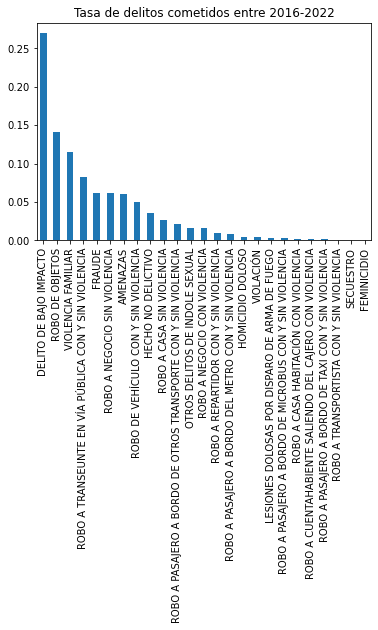

In [12]:
FGJ_carpetas["categoria_delito_homo"].value_counts(normalize=True).plot(kind = "bar", 
                                                                   title = "Tasa de delitos cometidos entre 2016-2022")

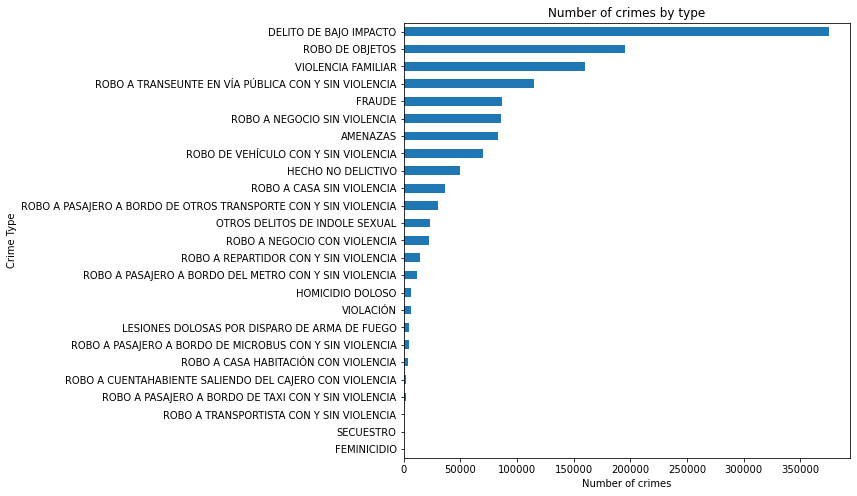

In [13]:
plt.figure(figsize=(8,8))
FGJ_carpetas.groupby([FGJ_carpetas['categoria_delito_homo']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by type')
plt.ylabel('Crime Type')
plt.xlabel('Number of crimes')
plt.show()

Nos llama la atención la categoria de **Delitos de bajo impacto**. Mostramos las primeras clases de delitos más frecuentes que son considerados de bajo impacto. 

Algo alarmante de ver aquí es que el **abuso sexual** se considera dentro de esta categoria, siendo incluso más frecuente que el sexto delito más frecuento de los que no son considerados como de bajo impacto.

In [14]:
pd.DataFrame(FGJ_carpetas[FGJ_carpetas["categoria_delito_homo"] == "DELITO DE BAJO IMPACTO"]["delito"].value_counts()).reset_index()[0:20]

index  delito
0                                  ABUSO DE CONFIANZA   23453
1                        NARCOMENUDEO POSESION SIMPLE   21899
2   DAÑO EN PROPIEDAD AJENA CULPOSA POR TRÁNSITO V...   21866
3                             USURPACIÓN DE IDENTIDAD   18799
4   FALSIFICACION DE TITULOS AL PORTADOR Y DOCUMEN...   18137
5                   LESIONES INTENCIONALES POR GOLPES   16232
6                 DAÑO EN PROPIEDAD AJENA INTENCIONAL   15496
7   LESIONES CULPOSAS POR TRANSITO VEHICULAR EN CO...   15130
8                              TENTATIVA DE EXTORSION   11616
9                     DAÑO EN PROPIEDAD AJENA CULPOSA   11504
10  PRODUCCIÓN, IMPRESIÓN, ENAJENACIÓN, DISTRIBUCI...   11038
11                        ROBO DE VEHICULO DE PEDALES    9921
12                                     ROBO DE DINERO    8589
13    DAÑO EN PROPIEDAD AJENA INTENCIONAL A AUTOMOVIL    8046
14  NARCOMENUDEO POSESIÓN CON FINES DE VENTA, COME...    6773
15                                      ENCUBRIMIENTO    6658
16                                 ROBO DE DOCUMENTOS    6459
17  ABUSO DE AUTORIDAD Y USO ILEGAL DE LA FUERZA P...    6104
18                         ROBO DE PLACA DE AUTOMOVIL    5727
19           LESIONES CULPOSAS POR TRANSITO VEHICULAR    5121

Vemos la cantidad de registros de delitos cometidos por año.

In [20]:
FGJ_carpetas.index.year.value_counts().sort_index()

2016    187319
2017    218043
2018    244732
2019    235368
2020    195039
2021    211468
2022     98729
Name: fecha_hechos, dtype: int64

Podemos ver que para el año 2022 hay pocos delitos, lo que no es de sorprenderse ya que el año aun esta en curso. 

Algo que si hay que notar, es que a partir del 2019 se nota una disminución en la cantidad de delitos, sobre todo para el año 2020. Podemos decir que el efecto COVID está presente. Quizás haya que considerar este efecto para futuros análisis.

<AxesSubplot:>

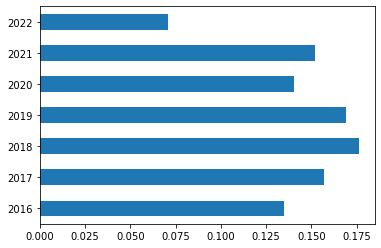

In [22]:
FGJ_carpetas.index.year.value_counts(normalize=True).sort_index().plot(kind = "barh")

Cantidad de delitos por mes.

In [23]:
FGJ_carpetas.index.month.value_counts().sort_index()

1     121395
2     121297
3     131641
4     118921
5     126749
6     119038
7     106360
8     110892
9     107766
10    115089
11    108552
12    102998
Name: fecha_hechos, dtype: int64

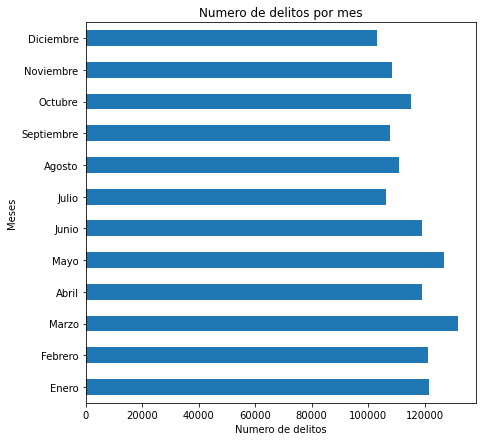

In [24]:
mes = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre",
      "Noviembre", "Diciembre"]
plt.figure(figsize=(7,7))
FGJ_carpetas.groupby([FGJ_carpetas.index.month]).size().plot(kind='barh', title = "Numero de delitos por mes")
plt.xlabel("Numero de delitos")
plt.ylabel("Meses")
plt.yticks(np.arange(12),mes)
plt.show()

Cantidad de delitos por día.

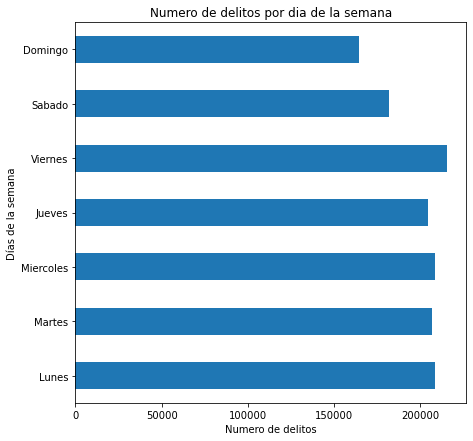

In [26]:
dias = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]
plt.figure(figsize=(7,7))
FGJ_carpetas.groupby([FGJ_carpetas.index.dayofweek]).size().plot(kind='barh', title = "Numero de delitos por dia de la semana")
plt.xlabel("Numero de delitos")
plt.ylabel("Días de la semana")
plt.yticks(np.arange(7),dias)
plt.show()

Cantidad de delitos por delegación. Podemos ver como Iztapalapa y Cuahtemoc son más *peligrosos*, por decirlo de alguna manera.

<AxesSubplot:>

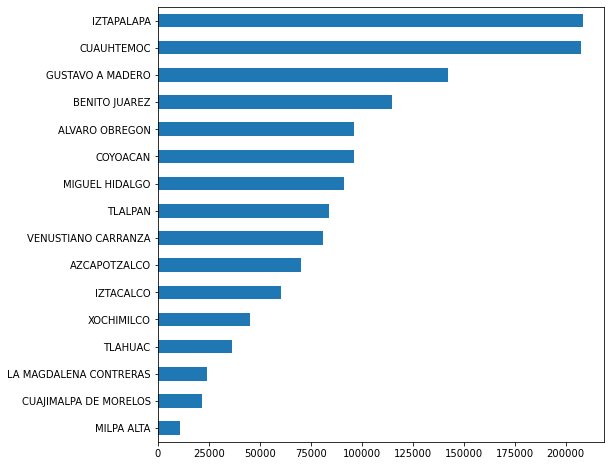

In [27]:
plt.figure(figsize=(8,8))
FGJ_carpetas["alcaldia_hechos"].value_counts().sort_values(ascending=True).plot(kind = "barh")

Observamos las distintas categorias en las que se encuentran clasificados los delitos.

In [27]:
FGJ_carpetas["categoria_delito_homo"].unique()

array(['DELITO DE BAJO IMPACTO', 'ROBO DE VEHICULO CON Y SIN VIOLENCIA',
       'ROBO A TRANSEUNTE EN VIA PUBLICA CON Y SIN VIOLENCIA',
       'VIOLENCIA FAMILIAR',
       'LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO',
       'HECHO NO DELICTIVO', 'ROBO A NEGOCIO SIN VIOLENCIA',
       'ROBO DE OBJETOS', 'AMENAZAS',
       'ROBO A PASAJERO A BORDO DE OTROS TRANSPORTE CON Y SIN VIOLENCIA',
       'ROBO A CASA SIN VIOLENCIA', 'ROBO A NEGOCIO CON VIOLENCIA',
       'OTROS DELITOS DE INDOLE SEXUAL',
       'ROBO A CASA HABITACION CON VIOLENCIA', 'FRAUDE',
       'ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA',
       'VIOLACION', 'ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA',
       'ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA',
       'ROBO A REPARTIDOR CON Y SIN VIOLENCIA', 'HOMICIDIO DOLOSO',
       'ROBO A PASAJERO A BORDO DE TAXI CON Y SIN VIOLENCIA',
       'ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA',
       'SECUESTRO', 'FEMINICIDIO'], dtype=object)

## Series de tiempo

Serie de tiempo por día. Podemos ver que es muy ruidosa.

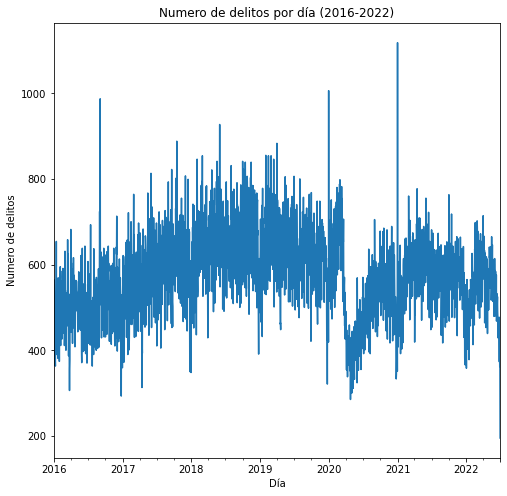

In [19]:
plt.figure(figsize=(8,8))
FGJ_carpetas.resample("D", on = "fecha_hechos").size().plot(legend = False, title = "Numero de delitos por día (2016-2022)")
plt.ylabel("Numero de delitos")
plt.xlabel("Día")
plt.show()

Serie por semana.

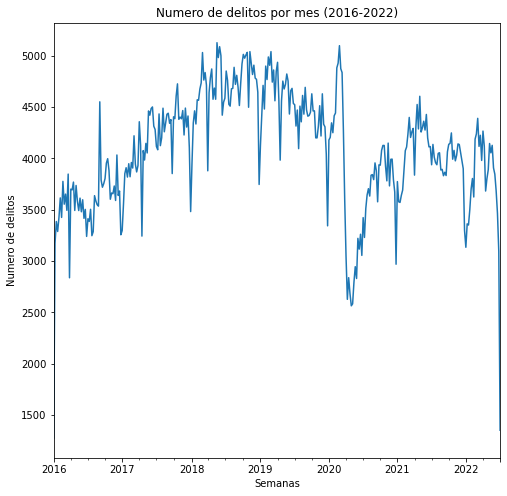

In [36]:
plt.figure(figsize=(8,8))
FGJ_carpetas.resample("W", on = "fecha_hechos").size().plot(legend = False, 
                                                                               title = "Numero de delitos por mes (2016-2022)")
plt.ylabel("Numero de delitos")
plt.xlabel("Semanas")
plt.show()

Serie mensual.

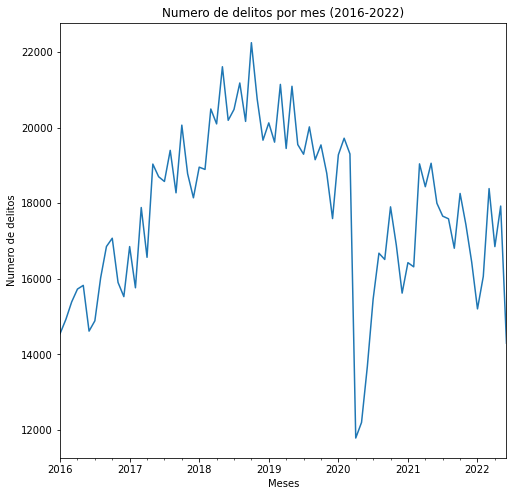

In [21]:
plt.figure(figsize=(8,8))
FGJ_carpetas.resample("M", on = "fecha_hechos").size().plot(legend = False, title = "Numero de delitos por mes (2016-2022)")
plt.ylabel("Numero de delitos")
plt.xlabel("Meses")
plt.show()

Serie anual.

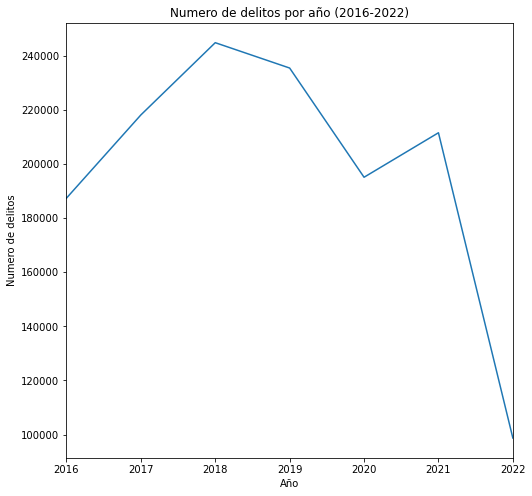

In [22]:
plt.figure(figsize=(8,8))
FGJ_carpetas.resample("Y", on = "fecha_hechos").size().plot(legend = False, title = "Numero de delitos por año (2016-2022)")
plt.ylabel("Numero de delitos")
plt.xlabel("Año")
plt.show()

### Análisis de estructura temporal por delito

Utilizando los registros de la base de datos se creo una tabla que contiene el número de delitos registrados dada ciertas ventanas de tiempo para cada uno de los delitos. Por cuestiones de visualización, a continuación solo se muestran las series de tiempo de los 10 delitos con más registros.

In [4]:
top_cat=FGJ_carpetas['categoria_delito_homo'].value_counts().index[:14]

In [5]:
ts_semana = FGJ_carpetas.pivot_table("delito",columns="categoria_delito_homo", aggfunc=np.size, fill_value=0, 
                                        index=FGJ_carpetas['fecha_hechos'].dt.to_period('W'))

In [6]:
idx_week=np.where(ts_semana.index.week==53)[0]
ts_semana.iloc[idx_week+1,:]=np.ceil((np.array(ts_semana.iloc[idx_week,:])+np.array(ts_semana.iloc[idx_week+1,:]))/2)
ts_semana=ts_semana.loc[ts_semana.index.week!=53,:]

array([[<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>]], dtype=object)

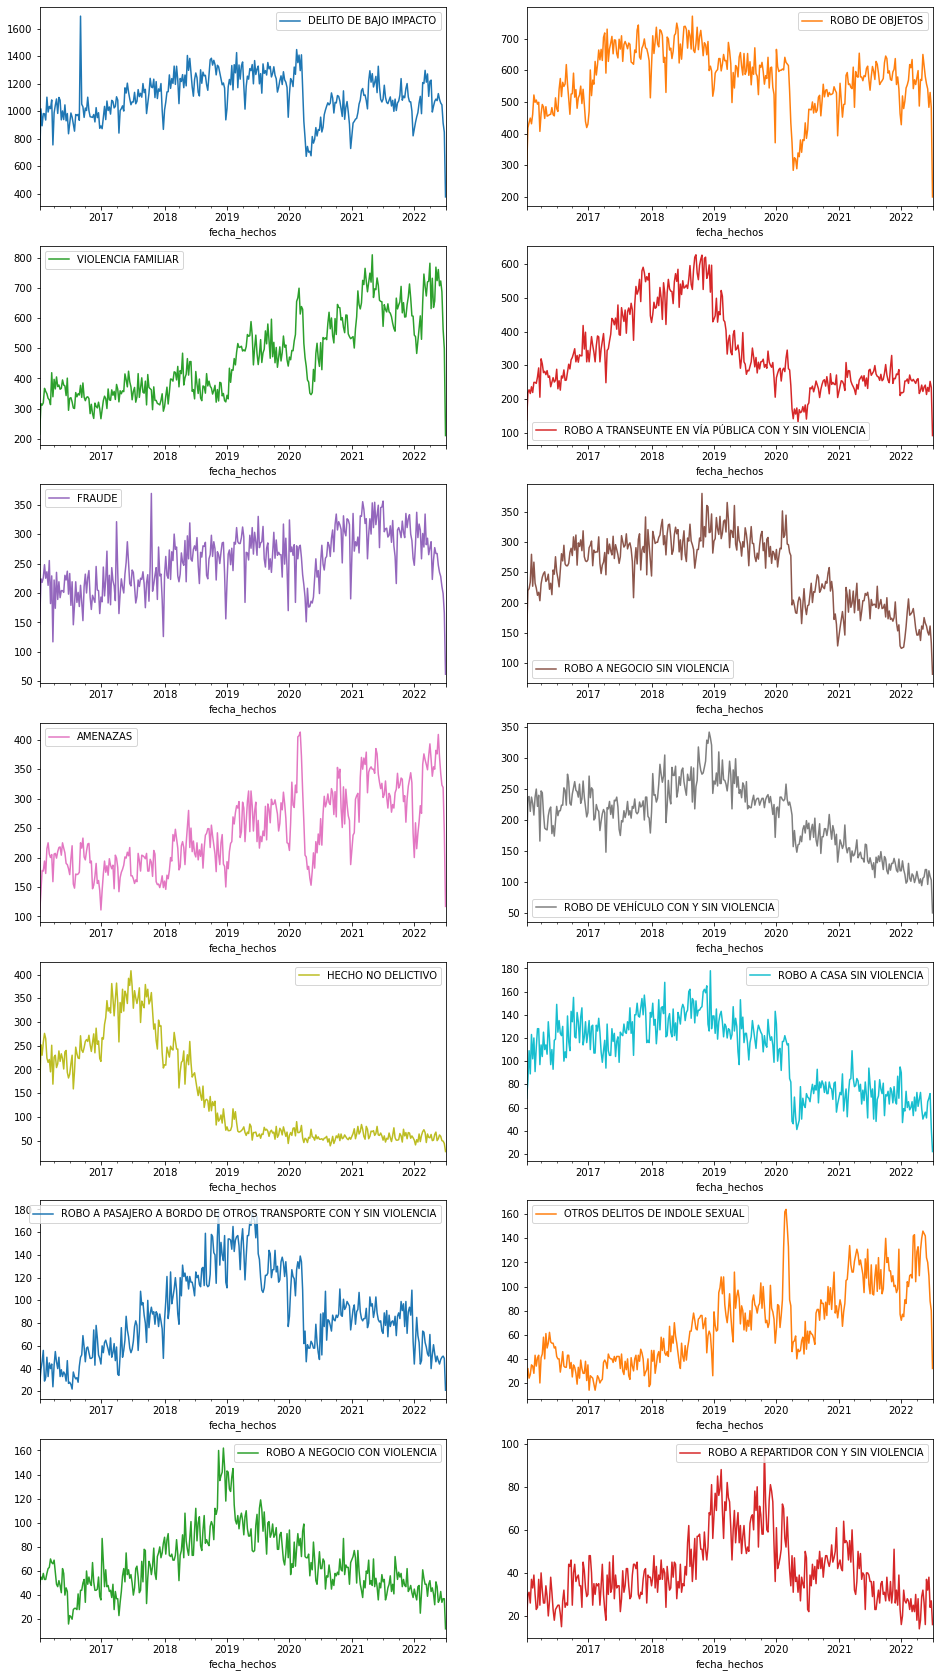

In [32]:
ts_semana.loc[:,top_cat].plot(figsize=(16, 30), subplots=True, layout=(-1, 2), sharex=False, sharey=False)

**Series por dia**

In [33]:
ts_dia = FGJ_carpetas.pivot_table("delito",columns="categoria_delito_homo", aggfunc=np.size, fill_value=0, 
                                        index=FGJ_carpetas['fecha_hechos'].dt.to_period('D'))

In [34]:
idx_day=np.where(ts_dia.index.dayofyear==366)[0]
ts_dia.iloc[idx_day+1,:]=np.ceil((np.array(ts_dia.iloc[idx_day,:])+np.array(ts_dia.iloc[idx_day+1,:]))/2)
ts_dia=ts_dia.loc[ts_dia.index.dayofyear!=366,:]

array([[<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>]], dtype=object)

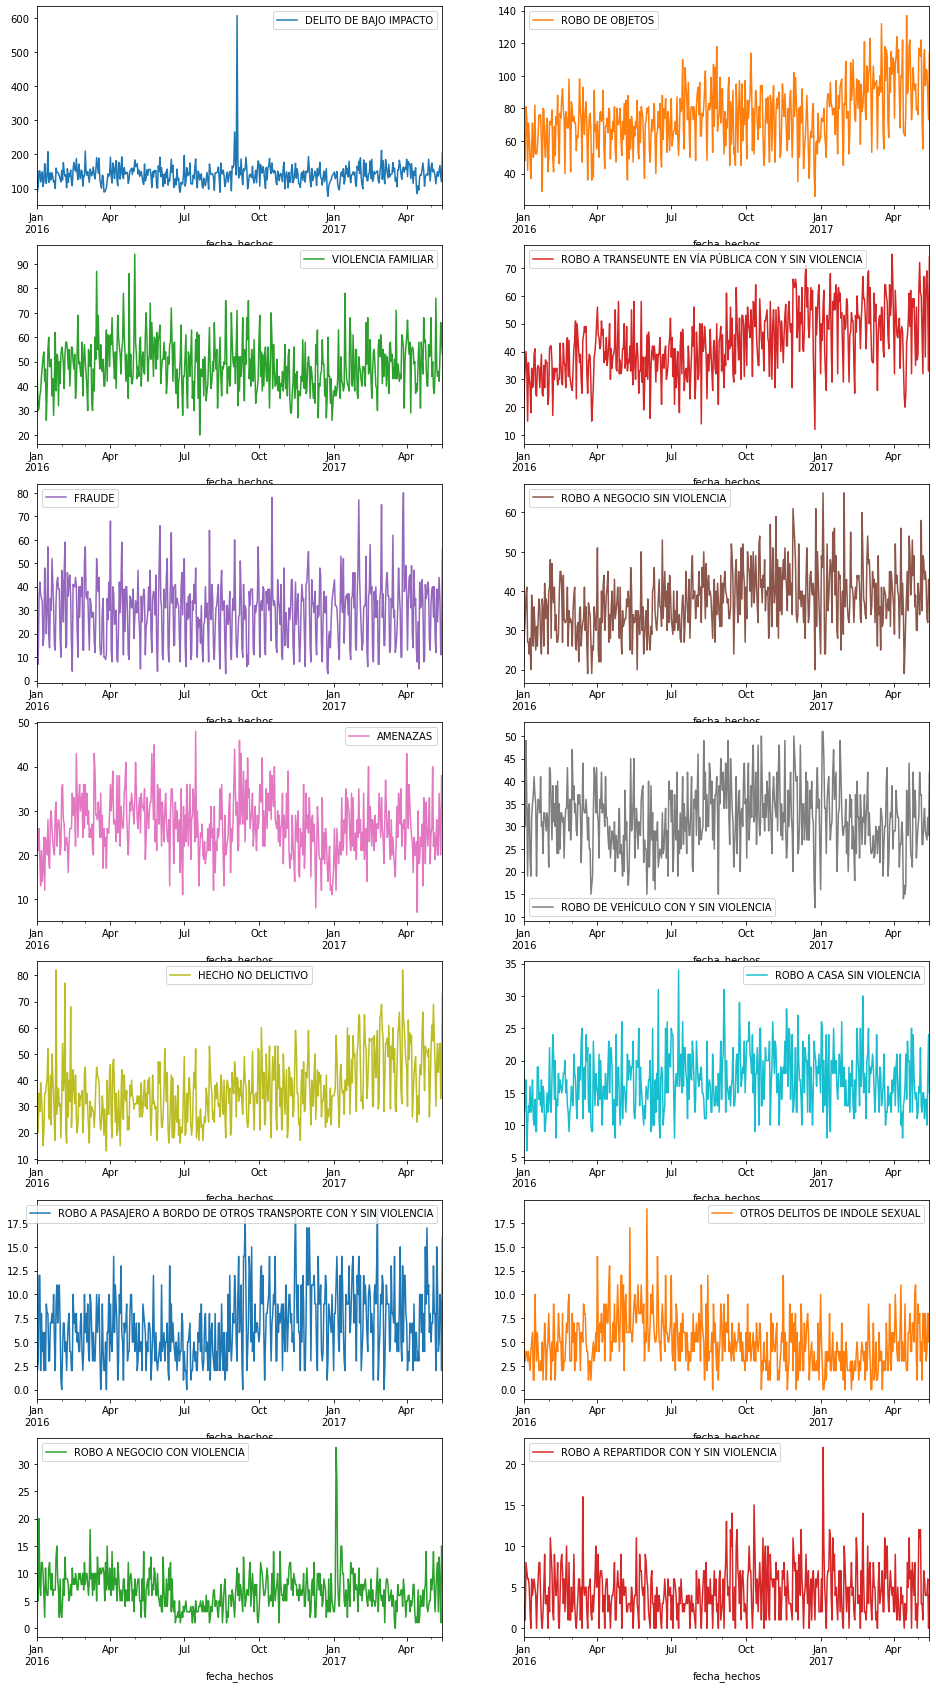

In [38]:
ts_dia.loc[:,top_cat].iloc[:500,].plot(figsize=(16, 30), subplots=True, layout=(-1, 2), sharex=False, sharey=False)

**Serie por hora**

In [16]:
ts_hora = FGJ_carpetas.pivot_table("delito",columns="categoria_delito_homo", aggfunc=np.size, fill_value=0, 
                                        index=FGJ_carpetas['fecha_hechos'].dt.to_period('H'))

array([[<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>]], dtype=object)

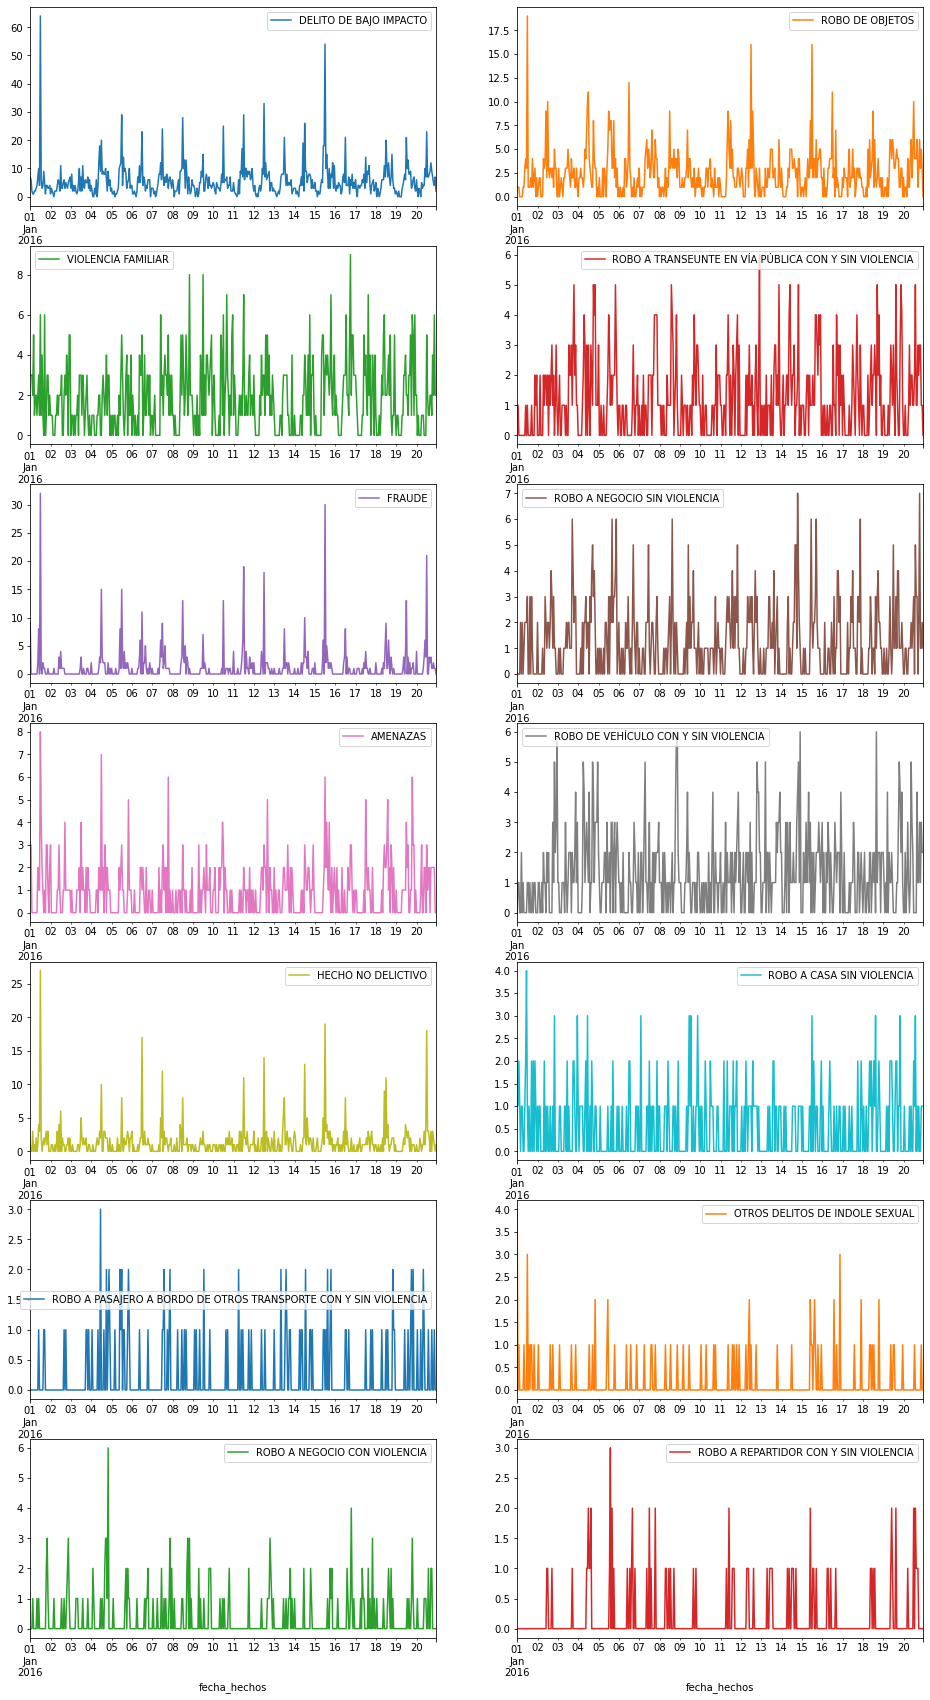

In [42]:
ts_hora.loc[:,top_cat].iloc[:480,:].plot(figsize=(16, 30), subplots=True, layout=(-1, 2), sharex=False, sharey=False)

#### Busqueda de patrones por la hora del delito

In [44]:
top_cat=FGJ_carpetas['categoria_delito_homo'].value_counts().index[1:12]
cat = top_cat[top_cat!="HECHO NO DELICTIVO"]

In [45]:
def scale_df(df,axis=0):
    return (df - df.mean(axis=axis)) / df.std(axis=axis)

def plot_hmap(df, ix=None, cmap='bwr'):
    if ix is None:
        ix = np.arange(df.shape[0])
    plt.imshow(df.iloc[ix,:], cmap=cmap)
    plt.colorbar(fraction=0.03)
    plt.yticks(np.arange(df.shape[0]), df.index[ix])
    plt.xticks(np.arange(df.shape[1]))
    plt.grid(False)
    plt.show()
    
def scale_and_plot(df, ix = None):
    df_marginal_scaled = scale_df(df.T).T
    if ix is None:
        ix = AC(4).fit(df_marginal_scaled).labels_.argsort()
    cap = np.min([np.max(df_marginal_scaled), np.abs(np.min(df_marginal_scaled))])
    df_marginal_scaled = np.clip(df_marginal_scaled, -1*cap, cap)
    plot_hmap(df_marginal_scaled, ix=ix)

In [46]:
cat_x_hora = FGJ_carpetas.pivot_table(values = "delito", index = "categoria_delito_homo", 
                         columns=FGJ_carpetas.index.hour, aggfunc=np.size).fillna(0)

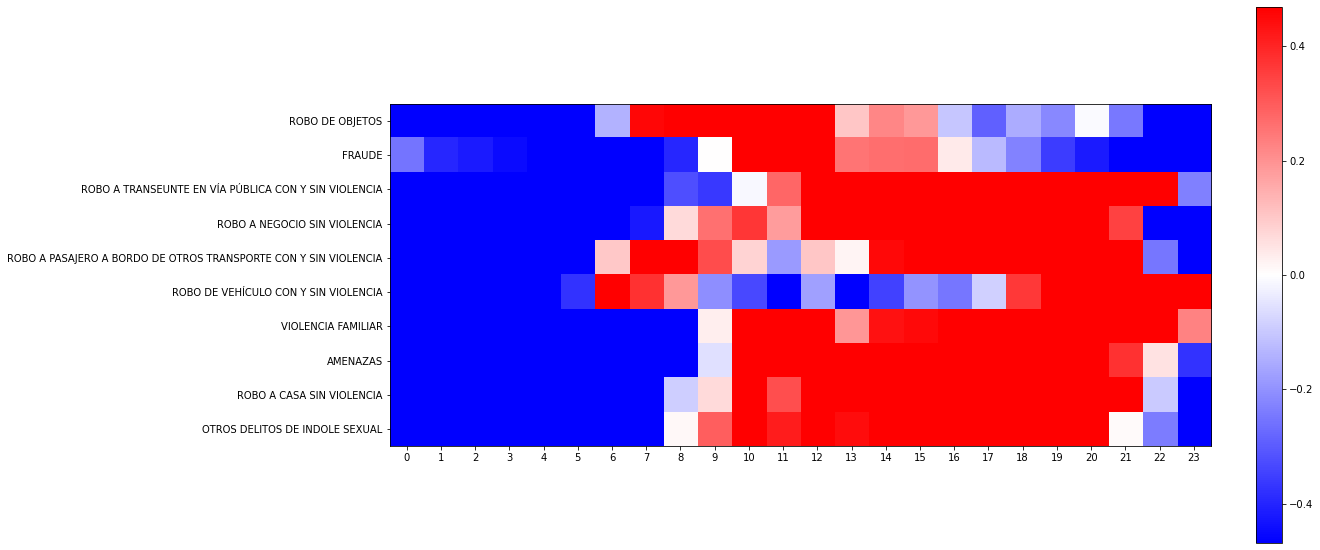

In [47]:
plt.figure(figsize=(16,10))
scale_and_plot(cat_x_hora.loc[cat,:])

Al graficar las series por separado de los delitos registrados por hora, se logra observar detalle la información del mapa de calor mostrado anteriormente.

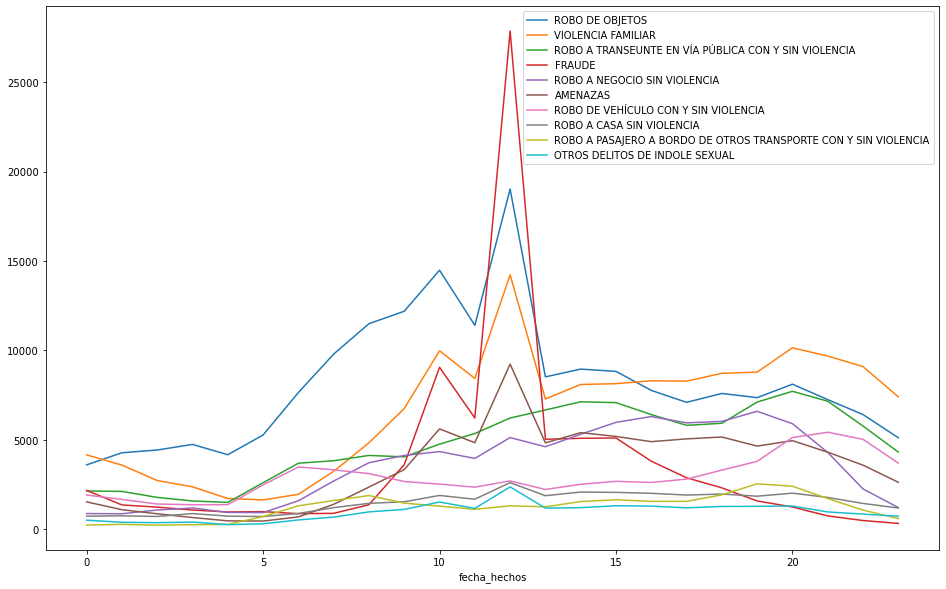

In [49]:
plt.figure(figsize=(16,10))
for i in range(10):
    cat_x_hora.loc[cat,:].iloc[i,].plot()
plt.legend()

Se observa que existen ciertos delitos de estudio que presentan una concentración de numero de delitos alrededor de las 12 pm. Por otro lado, otros delitos muestran una mayor concentracion de delitos en las noche.

**Relación entre tipo de delito y la semana de registro.**

In [67]:
cat_x_semana = FGJ_carpetas.pivot_table(values = "delito", index = "categoria_delito_homo", 
                                        aggfunc=np.size, fill_value=0, 
                                        columns=FGJ_carpetas.index.week)

C:\Users\110395\AppData\Local\Temp/ipykernel_12648/1203420629.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  columns=FGJ_carpetas.index.week)


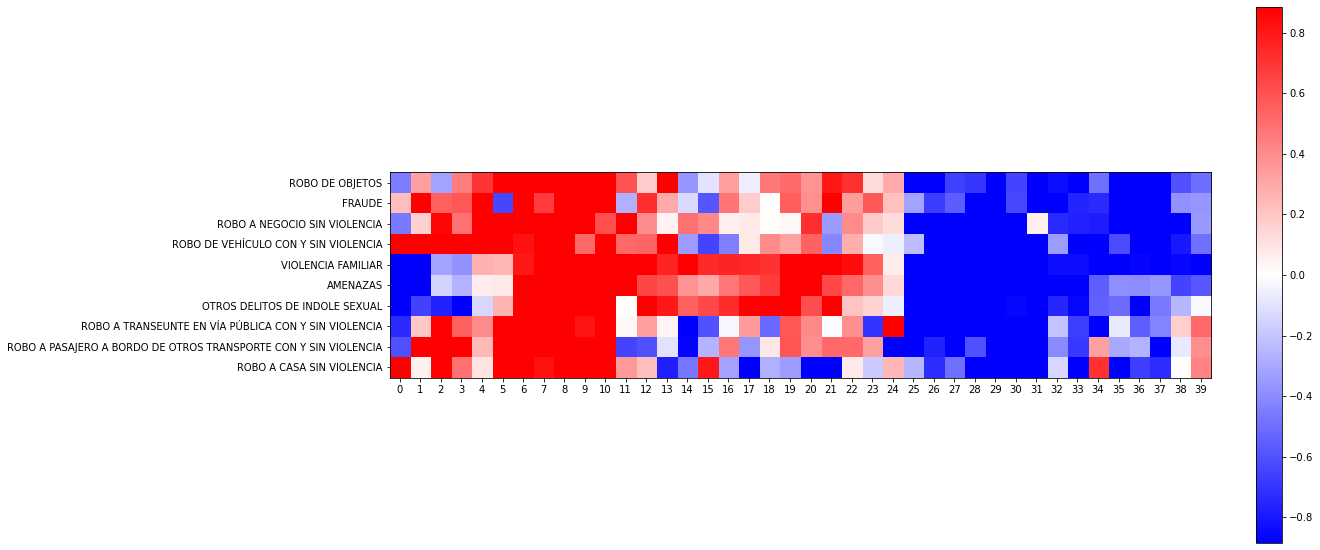

In [68]:
plt.figure(figsize=(16,10))
scale_and_plot(cat_x_semana.loc[cat,].iloc[:,:40])

Los delitos por semana muestra una actividad más uniforme presentando más delitos en las primeras 25 semanas.

**Relación entre tipo de delito y día del mes.**

In [69]:
cat_x_dia = FGJ_carpetas.pivot_table(values = "delito", index = "categoria_delito_homo", 
                         columns=FGJ_carpetas.index.day, aggfunc=np.size).fillna(0)

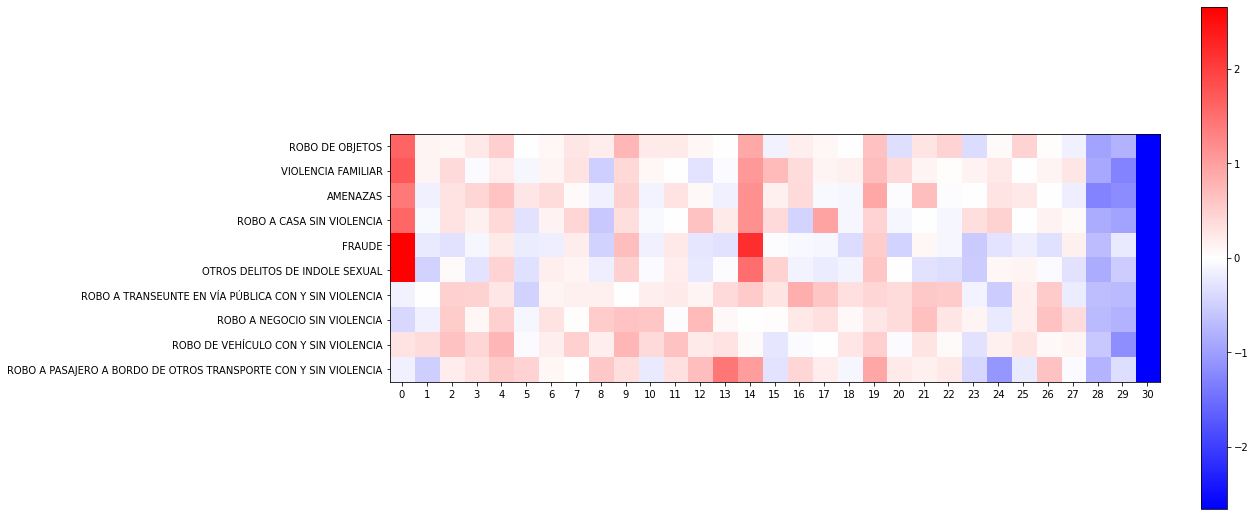

In [70]:
plt.figure(figsize=(15,12))
scale_and_plot(cat_x_dia.loc[cat,:])

**Relación entre tipo de delito y dia de la semana.**

In [71]:
cat_x_dia_semana = FGJ_carpetas.pivot_table(values = "delito", index = "categoria_delito_homo", 
                         columns=FGJ_carpetas.index.weekday, aggfunc=np.size).fillna(0)

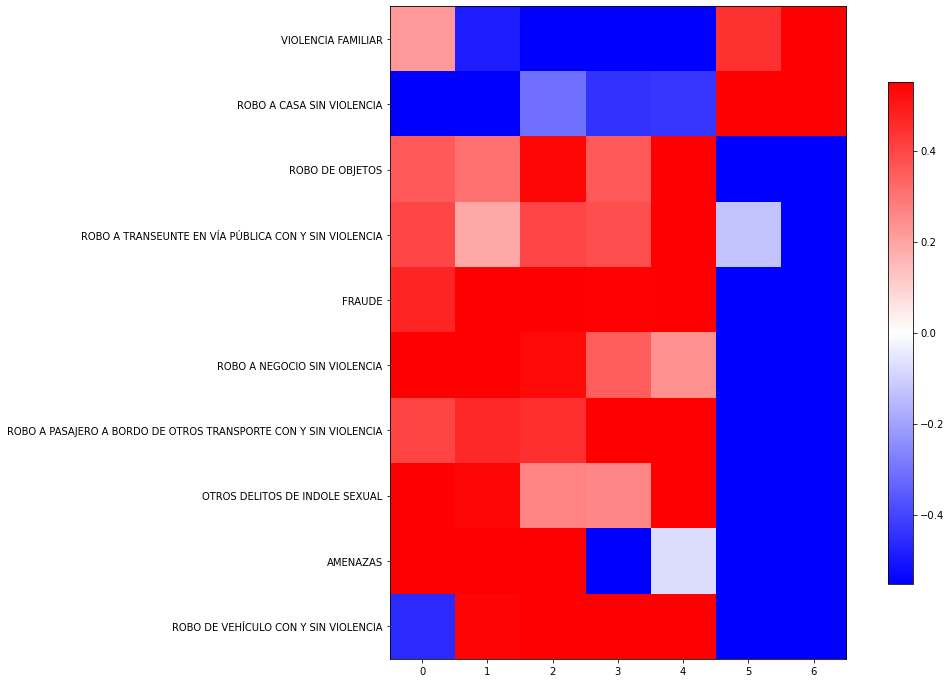

In [72]:
plt.figure(figsize=(15,12))
scale_and_plot(cat_x_dia_semana.loc[cat,:])

## Clustering a las Series por categoria: K-means

**Clustering con la metrica DTW**

In [9]:
top_cat=FGJ_carpetas['categoria_delito_homo'].value_counts().index[1:12]
cat = top_cat[top_cat!="HECHO NO DELICTIVO"]

In [10]:
km_euc = TimeSeriesKMeans(n_clusters=3, 
                          verbose=2, 
                          n_init=10, 
                          metric="euclidean").fit(ts_semana.loc[:,cat].transpose())
labels_euc = km_euc.labels_
print(silhouette_score(ts_semana.loc[:,cat].transpose(), labels_euc, metric="euclidean"))
print(labels_euc)

Init 1
4160043.100 --> 2930812.858 --> 2091498.030 --> 1871064.219 --> 1721564.627 --> 1721564.627 --> 
Init 2
3243602.300 --> 1721564.627 --> 1721564.627 --> 
Init 3
2957291.100 --> 1721564.627 --> 1721564.627 --> 
Init 4
3456645.300 --> 2984510.438 --> 2984510.438 --> 
Init 5
3425326.400 --> 1721564.627 --> 1721564.627 --> 
Init 6
5177503.900 --> 2476958.029 --> 2476958.029 --> 
Init 7
4148862.400 --> 2150053.954 --> 1871064.219 --> 1721564.627 --> 1721564.627 --> 
Init 8
4327135.400 --> 2150053.954 --> 1871064.219 --> 1721564.627 --> 1721564.627 --> 
Init 9
2656259.800 --> 1721564.627 --> 1721564.627 --> 
Init 10
3425326.400 --> 1721564.627 --> 1721564.627 --> 
0.46544777525801806
[1 1 0 0 0 0 0 2 2 2]


array([[<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>]], dtype=object)

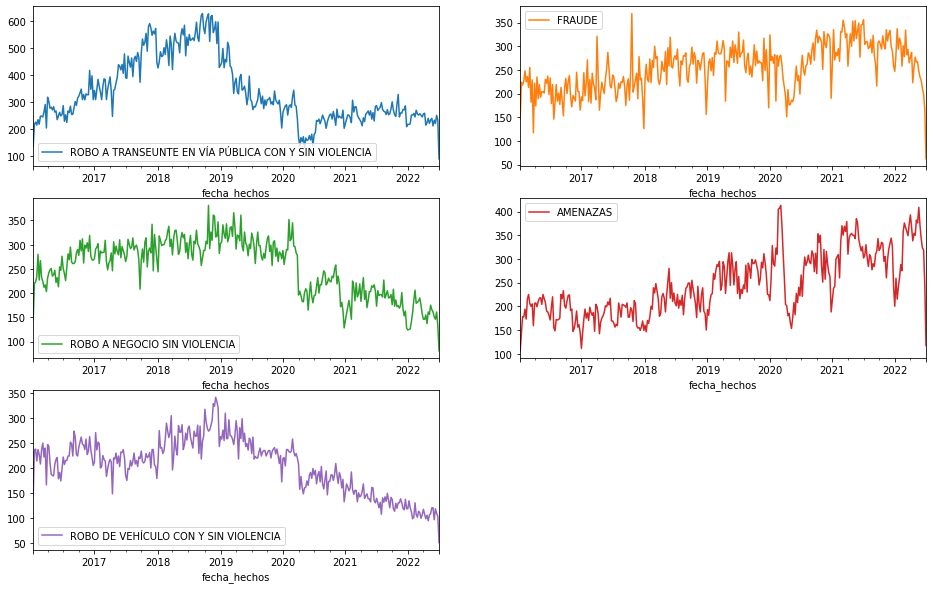

In [11]:
ts_semana.loc[:,cat].iloc[:,labels_euc==0].plot(figsize=(16, 10), subplots=True, layout=(-1, 2), sharex=False, sharey=False)

array([[<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>]], dtype=object)

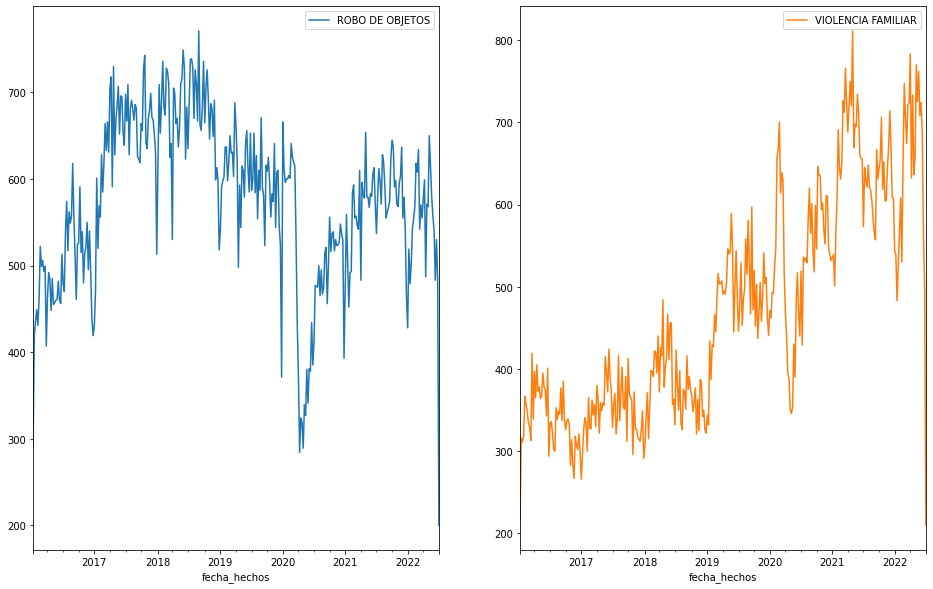

In [12]:
ts_semana.loc[:,cat].iloc[:,labels_euc==1].plot(figsize=(16, 10), subplots=True, layout=(-1, 2), sharex=False, sharey=False)

**Clustering con la metrica DTW**

In [13]:
km_dtw = TimeSeriesKMeans(n_clusters=3, 
                          verbose=2, 
                          n_init=10, 
                          metric="dtw").fit(ts_semana.loc[:,cat].transpose())
labels_dtw = km_dtw.labels_
print(silhouette_score(ts_semana.loc[:,cat].transpose(), labels_dtw, metric="dtw"))
print(labels_dtw)

Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


414699.600 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


190583.289 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


190583.289 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


400929.800 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


197972.291 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


197972.291 --> 
Init 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


498893.800 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


192755.039 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


192755.039 --> 
Init 4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


489996.200 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


171980.709 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


171980.709 --> 
Init 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


439183.700 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


179166.181 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


179166.181 --> 
Init 6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


971019.900 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


209424.254 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


209424.254 --> 
Init 7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


453121.500 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


185672.830 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


185672.830 --> 
Init 8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


375000.800 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


174885.347 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


174885.347 --> 
Init 9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


485956.800 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


181411.590 --> 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


181411.590 --> 
Init 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


375000.800 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


174885.347 --> 174885.347 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


0.6629469773757617
[1 1 1 2 2 2 2 0 0 0]


array([[<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>]], dtype=object)

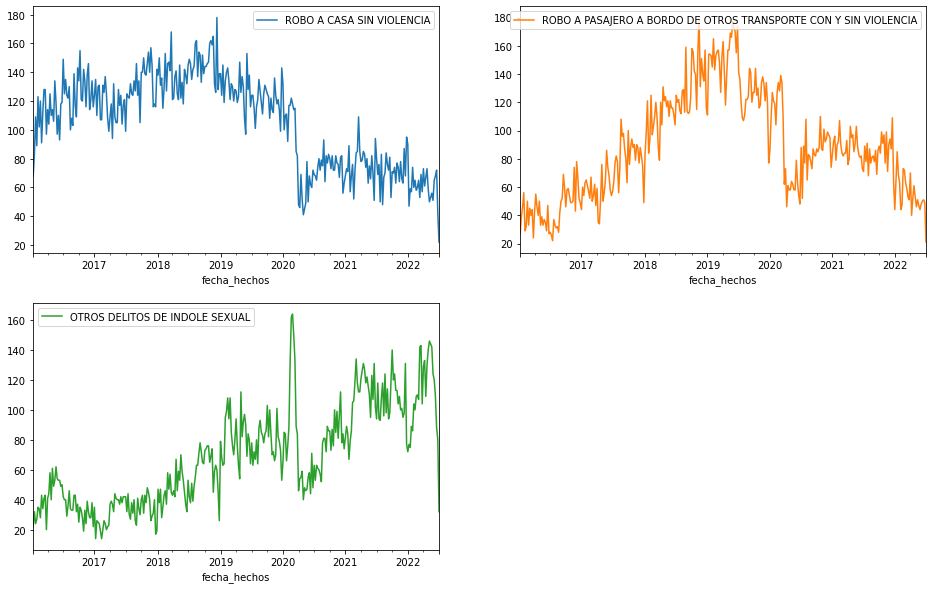

In [14]:
ts_semana.loc[:,cat].iloc[:,labels_dtw==0].plot(figsize=(16, 10), subplots=True, layout=(-1, 2), sharex=False, sharey=False)

array([[<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>]], dtype=object)

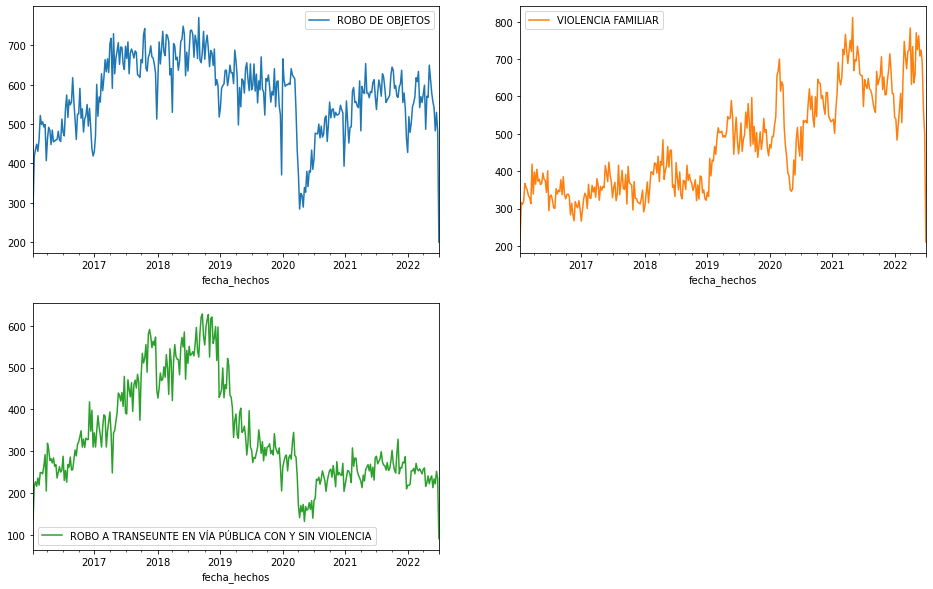

In [15]:
ts_semana.loc[:,cat].iloc[:,labels_dtw==1].plot(figsize=(16, 10), subplots=True, layout=(-1, 2), sharex=False, sharey=False)

In [17]:
km_euc = TimeSeriesKMeans(n_clusters=3, 
                          verbose=2, 
                          n_init=10, 
                          metric="euclidean").fit(ts_hora.loc[:,cat].transpose())
labels_euc = km_euc.labels_
print(silhouette_score(ts_hora.loc[:,cat].transpose(), labels_euc, metric="euclidean"))
print(labels_euc)

Init 1
182672.600 --> 105149.067 --> 105149.067 --> 
Init 2
181093.800 --> 95806.129 --> 95806.129 --> 
Init 3
202354.000 --> 121014.350 --> 121014.350 --> 
Init 4
165284.300 --> 104505.312 --> 104505.312 --> 
Init 5
173859.000 --> 95806.129 --> 95806.129 --> 
Init 6
180662.300 --> 104505.312 --> 104505.312 --> 
Init 7
191945.500 --> 116883.636 --> 116883.636 --> 
Init 8
171691.800 --> 109984.745 --> 109984.745 --> 
Init 9
182672.600 --> 105149.067 --> 105149.067 --> 
Init 10
173859.000 --> 95806.129 --> 95806.129 --> 
0.2817204582499557
[0 0 1 2 1 1 1 1 1 1]


array([[<AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>]], dtype=object)

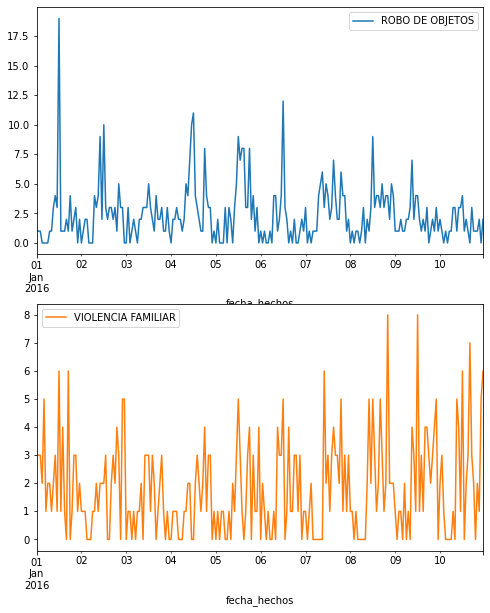

In [24]:
ts_hora.loc[:,cat].iloc[:240,labels_euc==0].plot(figsize=(8, 10), subplots=True, layout=(-1, 1), sharex=False, sharey=False)

array([[<AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>]], dtype=object)

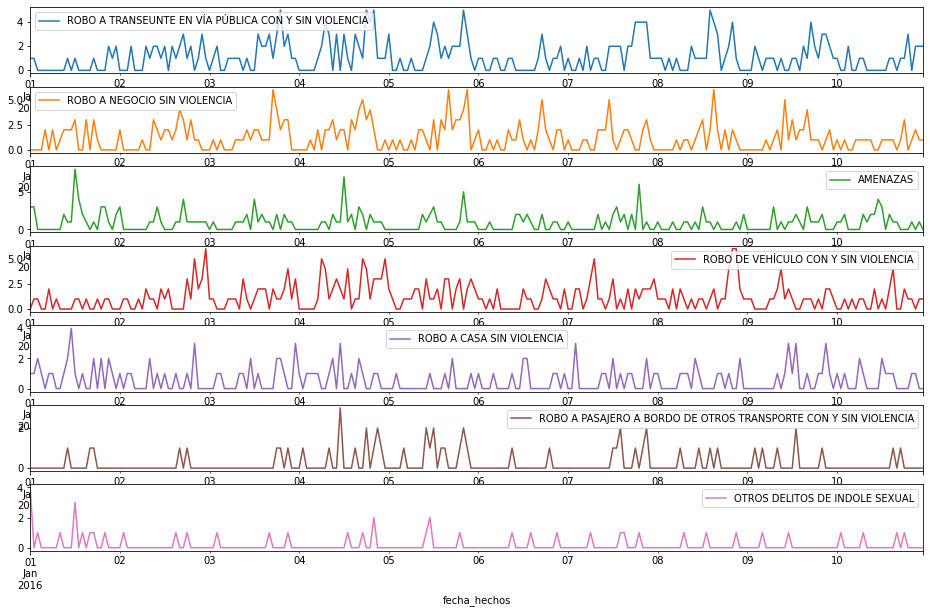

In [27]:
ts_hora.loc[:,cat].iloc[:240,labels_euc==1].plot(figsize=(16, 10), subplots=True, layout=(-1, 1), sharex=False, sharey=False)

## Analisis de estructura espacial

Vemos las zonas donde mayor se concentran los delitos.

(19.08, 19.6)

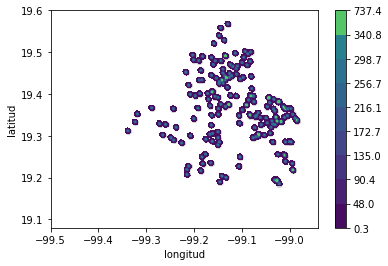

In [28]:
crimes_new = FGJ_carpetas[FGJ_carpetas['categoria_delito_homo'] == 'SECUESTRO']
sns.regplot(x='longitud', y='latitud', data= crimes_new[['longitud','latitud']], fit_reg=False, scatter_kws={"color":"grey","alpha":0.3})
sns.kdeplot(data = crimes_new[['latitud','longitud']], x = "longitud", y="latitud",
                 cmap="viridis", 
                 bw_method=.02,
                 #n_levels=10,
                 cbar=True, 
                 shade=True, 
                 thresh=0.0005, warn_singular=False)
plt.xlim(-99.5,-98.94)
plt.ylim(19.08,19.6)


Ahora lo hacemos por tipo de delito. Algo a mejorar en esta parte es graficar estos puntos sobre el mapa de CDMX para saber en que delegaciones son estas manchas.

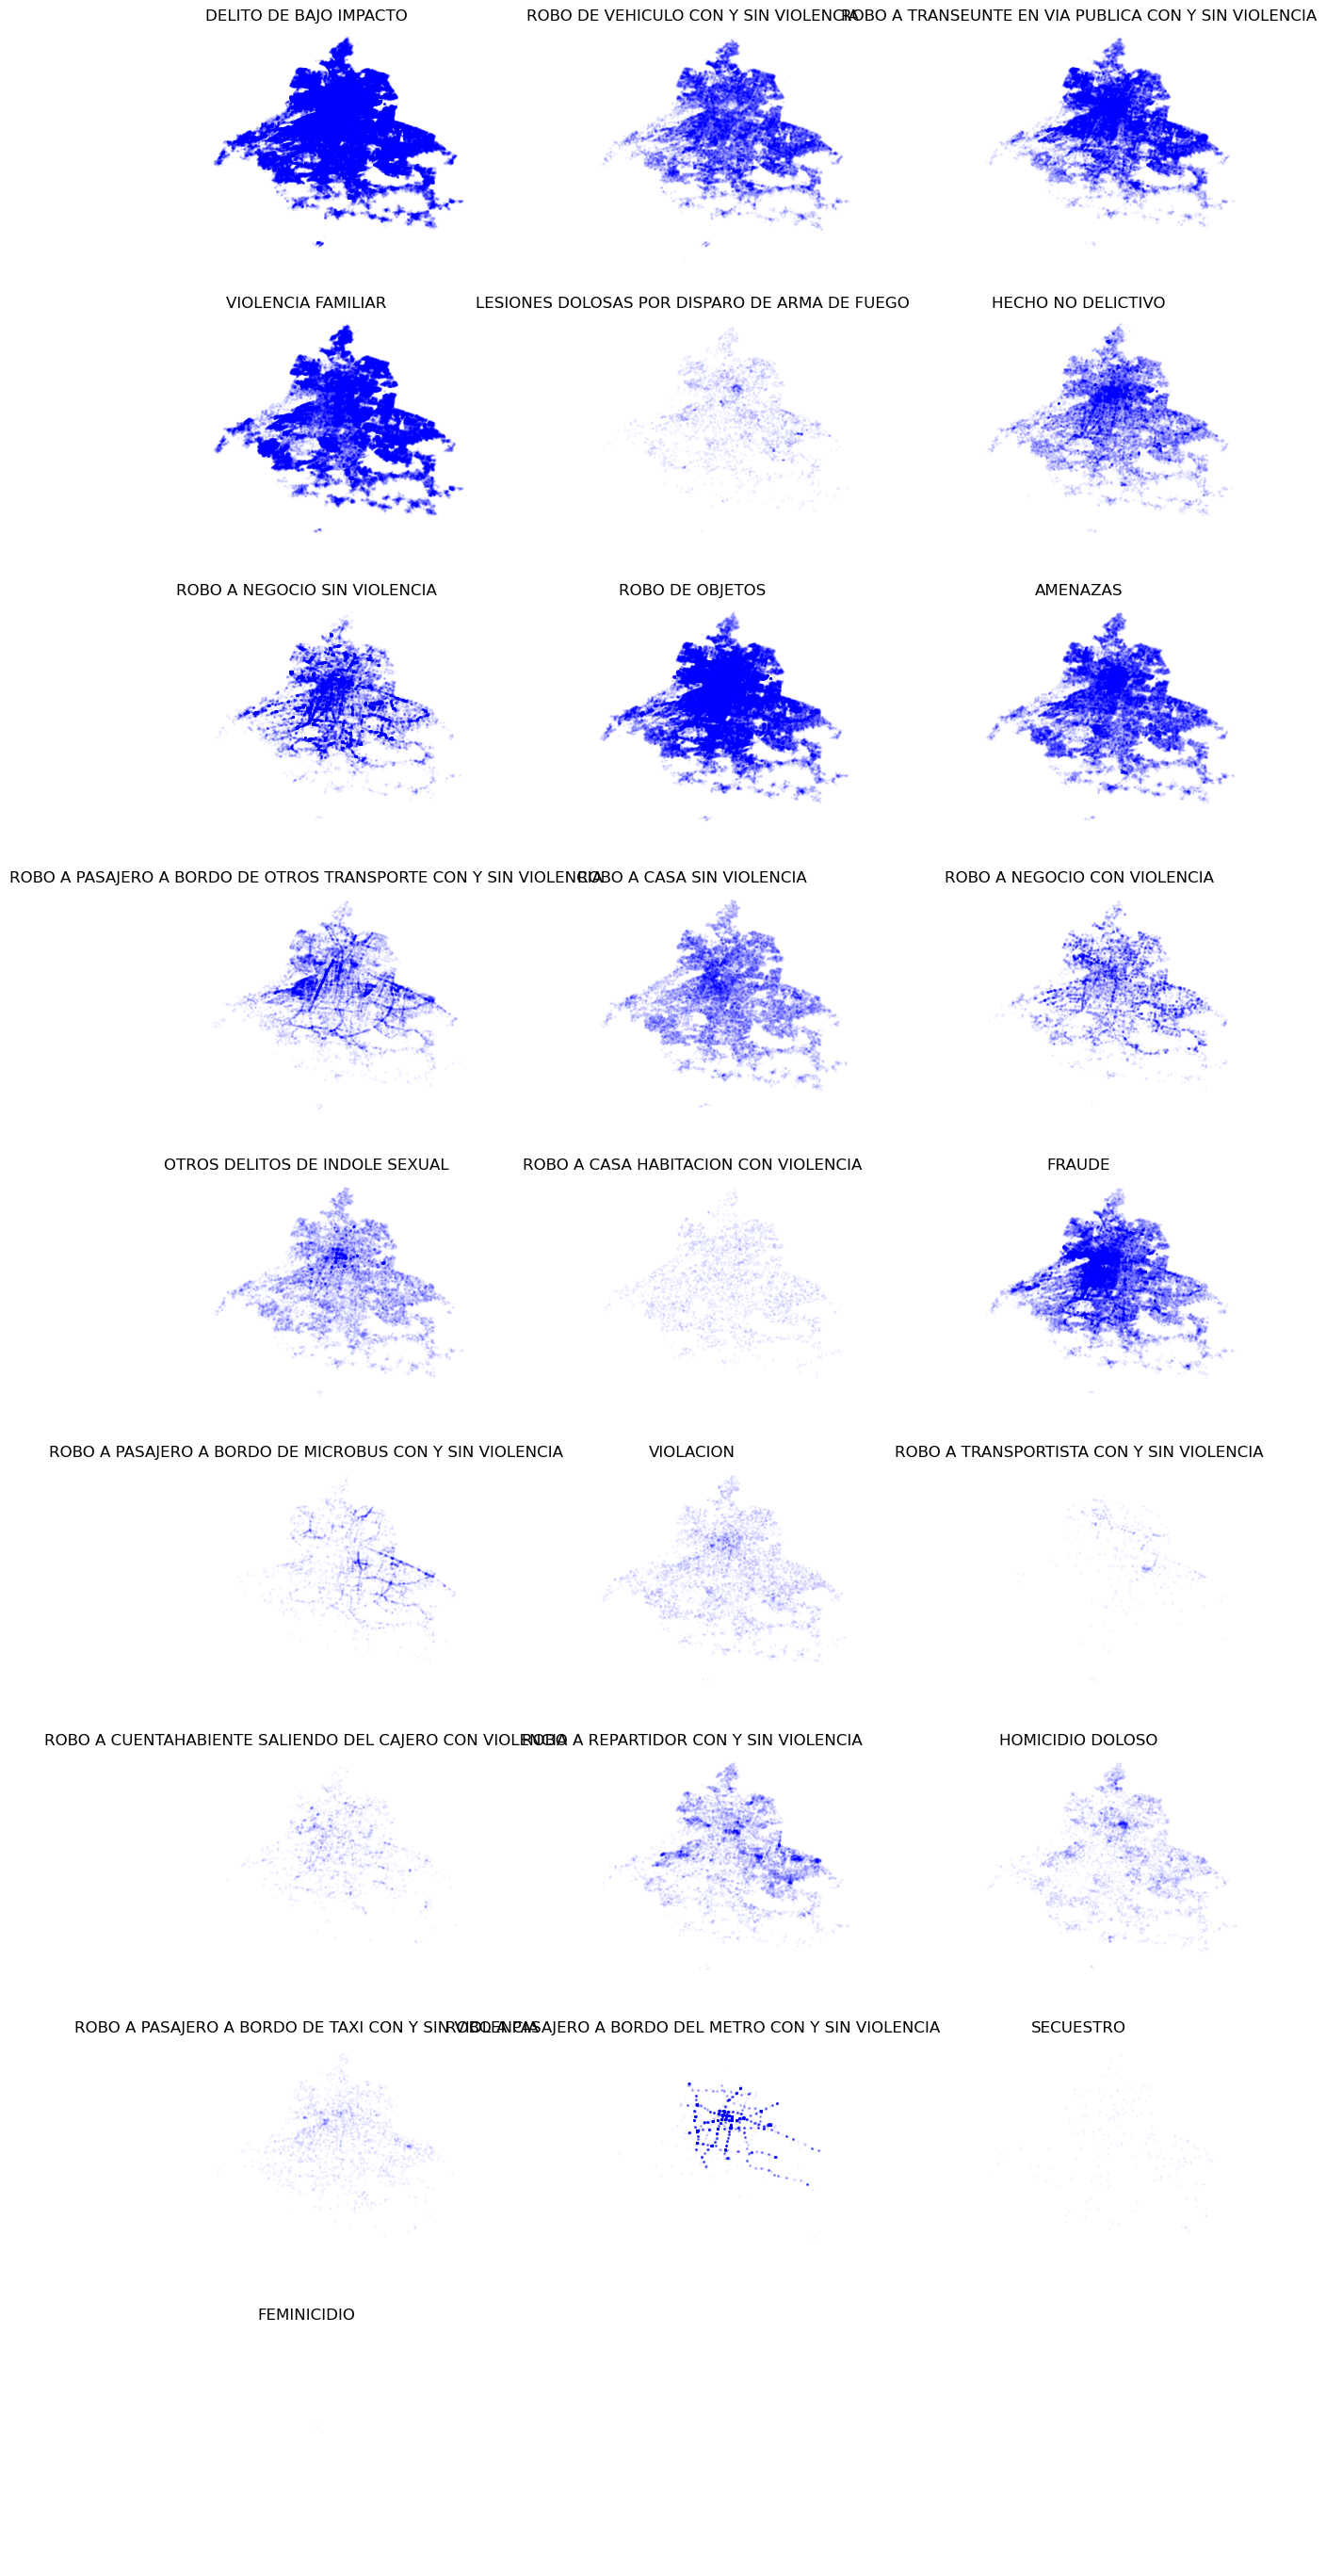

In [28]:
delitos =['DELITO DE BAJO IMPACTO', 'ROBO DE VEHICULO CON Y SIN VIOLENCIA',
       'ROBO A TRANSEUNTE EN VIA PUBLICA CON Y SIN VIOLENCIA',
       'VIOLENCIA FAMILIAR',
       'LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO',
       'HECHO NO DELICTIVO', 'ROBO A NEGOCIO SIN VIOLENCIA',
       'ROBO DE OBJETOS', 'AMENAZAS',
       'ROBO A PASAJERO A BORDO DE OTROS TRANSPORTE CON Y SIN VIOLENCIA',
       'ROBO A CASA SIN VIOLENCIA', 'ROBO A NEGOCIO CON VIOLENCIA',
       'OTROS DELITOS DE INDOLE SEXUAL',
       'ROBO A CASA HABITACION CON VIOLENCIA', 'FRAUDE',
       'ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA',
       'VIOLACION', 'ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA',
       'ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA',
       'ROBO A REPARTIDOR CON Y SIN VIOLENCIA', 'HOMICIDIO DOLOSO',
       'ROBO A PASAJERO A BORDO DE TAXI CON Y SIN VIOLENCIA',
       'ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA',
       'SECUESTRO', 'FEMINICIDIO']

fig = plt.figure(figsize=(15,35))
for i, cat_deli in enumerate(delitos):
    ax = fig.add_subplot(int(np.ceil(float(len(delitos)) / 3)), 3, i+1)
    delitos_cat = FGJ_carpetas[FGJ_carpetas['categoria_delito_homo']==cat_deli]
    sns.regplot(x='longitud', y='latitud', data= delitos_cat[['longitud','latitud']], fit_reg=False, 
                scatter_kws={'alpha':.03, 'color':'blue', "s":1}, ax=ax)
    ax.set_title(cat_deli)
    ax.set_xlim(-99.45,-98.94)
    ax.set_ylim(19.08,19.6)
    ax.set_axis_off()
        
plt.show()